In [21]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sympy
from operator import itemgetter
from sympy.physics.quantum.cg import CG

In [22]:
%run Q_and_M_database.ipynb

Number of misbehaved entries:  1
Total number of entries analyzed:  1208
Total number of entries uncleaned:  1208
Total number of entries inserted:  1175
Long lived magnetic dipole moments loaded as M_LL
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, mu, un].
Number of misbehaved entries:  65
Total number of entries analyzed:  1356
Total number of entries uncleaned:  1356
Total number of entries inserted:  1164
Short lived magnetic dipole moments loaded as M_SL
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, q, un, E, jp].
Magnetic dipole moments loaded as M
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, mu, un].
Total number of entries uncleaned:  2564
Total number of entries inserted:  2339
Number of misbehaved entries:  164
Total number of entries analyzed:  1468
Total number of entr

## Hamiltonian and H.O. radial wavefunctions

In [3]:
# Constants

hbar = 6.582119569*10**(-22)           # MeV*s
c = 2.99792458*10**(8)*10**(15)        # fm/s
m_p = 938.27/c**2                      # MeV*s²/fm²
m_n = 939.57/c**2                      # MeV*s²/fm²

def hbaromega(A):                          # Parameters: A mass number of nucleus
    return 45*A**(-1/3) - 25*A**(-2/3) 

def b(m,A):                                # Parameters: m mass of nucleon, A mass number of nucleus
    return hbar/np.sqrt(m*hbaromega(A))

In [4]:
# Harmonic oscillator radial wavefunction

def psiHO(r, n, l, m, A):                 # Parameters: r coordinate, n radial quantum number
                                          #             l orbital angular momentum,
                                          #             m mass of nucleon, A mass number of nucleus
    bv = b(m,A)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv**3*scp.special.gamma(n+l+3/2)))
    return norm*(r/bv)**l*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)

In [5]:
# Harmonic oscillator total wavefunction

def PSI_HO(r, th, ph, n, l, j, proj, m, A):    # Parameters: r coordinate, n radial quantum number, th theta coordinate, ph azimutal coordinate
                                               #             l orbital angular momentum,
                                               #             j total angular momentum,
                                               #             proj is the projection of the total angular momentum
                                               #             m mass of nucleon, A mass number of nucleus
    bv = b(m,A)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv**3*scp.special.gamma(n+l+3/2)))
    radial_wf = norm*(r/bv)**l*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)

    ang_spin_wf = np.array([0+0j,0+0j])
    for ml in range(-l,l+1):
        for ms in np.arange(-1/2,1/2+1,1):
            
            if ms == 1/2:
                ang_spin_wf += float(CG(l, ml, 1/2, ms, j, proj).doit())*scp.special.sph_harm(ml, l, th, ph)*np.array([1+0j, 0+0j])
            
            if ms == -1/2:
                ang_spin_wf += float(CG(l, ml, 1/2, ms, j, proj).doit())*scp.special.sph_harm(ml, l, th, ph)*np.array([0+0j, 1+0j])

    return radial_wf*ang_spin_wf

In [6]:
def wavefunction_evaluator(n, l, j, proj, m, A, x_interval, y_interval, z_interval, density):
    
    wf = []
    
    X = np.linspace(x_interval[0], x_interval[1], density)
    Y = np.linspace(y_interval[0], y_interval[1], density)
    Z = np.linspace(z_interval[0], z_interval[1], density)
    
    #probsum = 0
    
    for x in X:
        for y in Y:
            for z in Z:
                    
                r  = np.sqrt(x**2 + y**2 + z**2)
                th = np.arccos(z/r)
                ph = np.arctan(y/x) 
                
                ampl = PSI_HO(r, th, ph, n, l, j, proj, m, A)
                prob = abs(np.dot(ampl, np.conjugate(ampl)))
                
                wf.append([x,y,z,prob])
                
                #probsum += prob                
    return wf

In [7]:
# Function to compute <r^2>

def Integrand(r,n,l,m,N,Z,part):          # Parameters: r coordinate, n1, n2 radial quantum numbers, 
                                          #             l orbital angular momentum, N number of neutrons,
                                          #             Z number of protons, part = 0 for proton and 
                                          #             1 for neutron
    f1 = psiHO(r, n, l, m, Z+N)
    
    return r**4*f1*f1

def MSR(n,l,m,N,Z,part):
    
    return scp.integrate.quad(Integrand, 0, 200, args=(n,l,m,N,Z,part))[0]   # Integral up to 200fm

In [8]:
def Q_sp(n, l, m, N, Z, part):
    
    j1 = l+1/2
    j2 = l-1/2
    msr = MSR(n,l,m,N,Z,part)
    
    if l == 0:
        return [[2*j1, -1*part*(2*j1-1)/(2*j1+2)*msr]]
    else:
        return [[2*j1, -1*(1-part)*(2*j1-1)/(2*j1+2)*msr], [2*j2, -1*(1-part)*(2*j2-1)/(2*j2+2)*msr]]

In [9]:
def M_sp(j_max):
    
    gl_n = 0
    gl_p = 1
    gs_n = -3.826 
    gs_p = 5.586
    
    mump = []
    mupp = []
    mumn = []
    mupn = []
    
    jj = []
    
    for j in np.arange(0.5, j_max+1, 1):
        
        jj.append(j)
        mump.append(gl_p*j-(gs_p-gl_p)*(j)/(2*j+2))
        mupp.append(gl_p*j + (gs_p-gl_p)/2)
        
        mumn.append(gl_n*j-(gs_n-gl_n)*(j)/(2*j+2))
        mupn.append(gl_n*j + (gs_n-gl_n)/2)
        
    return jj, mump, mupp, mumn, mupn

# Wave function probability distribution 

In [12]:
wf = np.array(wavefunction_evaluator(0, 1, 1/2, 1/2, m_p, 27,[-8,8], [-8,8], [-8,8], 30))
wf1 = np.array(wavefunction_evaluator(0, 1, 3/2, 3/2, m_p, 27,[-8,8], [-8,8], [-8,8], 30))
wf2 = np.array(wavefunction_evaluator(0, 2, 5/2, 5/2, m_p, 27,[-8,8], [-8,8], [-8,8], 30))

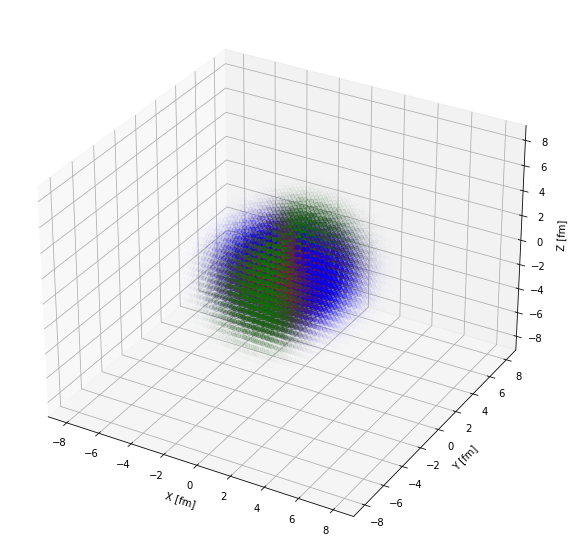

In [13]:
#%matplotlib notebook

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")

maximum_prob = max(wf[:,3])
maximum_prob1 = max(wf1[:,3])
maximum_prob2 = max(wf2[:,3])

for i in range(len(wf)):
    ax.scatter(wf[i][0],wf[i][1],wf[i][2], alpha=wf[i][3]/maximum_prob, color = "blue")
    ax.scatter(wf1[i][0],wf1[i][1],wf1[i][2], alpha=wf1[i][3]/maximum_prob1, color = "red")
    ax.scatter(wf2[i][0],wf2[i][1],wf2[i][2], alpha=wf2[i][3]/maximum_prob2, color = "green")

ax.set_xlabel('X [fm]')
ax.set_ylabel('Y [fm]')
ax.set_zlabel('Z [fm]')

plt.show()

# what nucleus is it above???

# =======================================================

# MAKE THE FOLLOWING ISOTOPES ODD-MASSED?? REALLY WHAT IF THIS IS THE INTRINSIC AND THAT IS IT

# =======================================================

# Quadrupole moments

In [50]:
Qs = np.array(Q_sp(0, 0, m_p, 2, 2, 0))  # 4He
Qp = np.array(Q_sp(0, 1, m_p, 5, 5, 0))  # 10B
Qsd = np.array(Q_sp(0, 2, m_p, 10, 10, 0) + Q_sp(2, 0, m_p, 10, 10, 0))   # 20Ne
Qpf = np.array(Q_sp(1, 1, m_p, 26, 24, 0) + Q_sp(0, 3, m_p, 26, 24, 0))   # 50Cr
Qsdg = np.array(Q_sp(2, 0, m_p, 90, 64, 0) + Q_sp(1, 2, m_p, 90, 64, 0) + Q_sp(0, 4, m_p, 90, 64, 0))  # 154Ga
Qpfh = np.array(Q_sp(2, 1, m_p, 134, 90, 0) + Q_sp(1, 3, m_p, 134, 90, 0) + Q_sp(0, 5, m_p, 134, 90, 0))  # 224Th

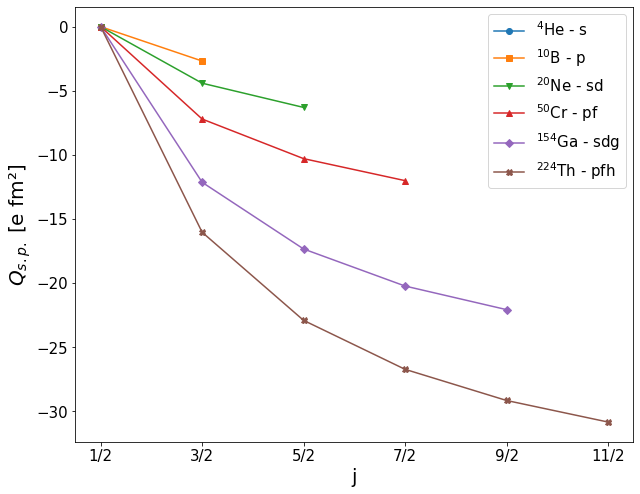

In [51]:
plt.figure(figsize=((10,8)))

Qs[:,0], Qs[:,1] = zip(*sorted(zip(Qs[:,0], Qs[:,1])))
plt.plot(Qs[:,0]/2, Qs[:,1],"o-",zorder=20, color="C0", label = r"$^{4}$He - s")
   
Qp[:,0], Qp[:,1] = zip(*sorted(zip(Qp[:,0], Qp[:,1])))
plt.plot(Qp[:,0]/2, Qp[:,1],"s-",zorder=20, color="C1", label = r"$^{10}$B - p")

Qsd[:,0], Qsd[:,1] = zip(*sorted(zip(Qsd[:,0], Qsd[:,1])))
plt.plot(Qsd[:,0]/2, Qsd[:,1],"v-",zorder=20, color="C2", label = r"$^{20}$Ne - sd")
    
Qpf[:,0], Qpf[:,1] = zip(*sorted(zip(Qpf[:,0], Qpf[:,1])))
plt.plot(Qpf[:,0]/2, Qpf[:,1],"^-",zorder=20, color="C3", label = r"$^{50}$Cr - pf")   
    
Qsdg[:,0], Qsdg[:,1] = zip(*sorted(zip(Qsdg[:,0], Qsdg[:,1])))
plt.plot(Qsdg[:,0]/2, Qsdg[:,1],"D-",zorder=20, color="C4", label = r"$^{154}$Ga - sdg")

Qpfh[:,0], Qpfh[:,1] = zip(*sorted(zip(Qpfh[:,0], Qpfh[:,1])))
plt.plot(Qpfh[:,0]/2, Qpfh[:,1],"X-",zorder=20, color="C5", label = r"$^{224}$Th - pfh")
    

def Q_empirical(j,A):
    return -(2*j-1)/(2*j+2)*3/5*A**(2/3)*1.2**2

#plt.plot(np.array([0.5,1.5,2.5,3.5,4.5]), np.array([Q_empirical(0.5,4), Q_empirical(1.5,10), Q_empirical(2.5,20), Q_empirical(3.5,50), Q_empirical(4.5,154)]), "o-",zorder=1, color="red")

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5],["1/2","3/2","5/2","7/2","9/2","11/2"], fontsize=15)
plt.yticks( fontsize=15)

#plt.plot([0.5,1.5,2.5,3.5,4.5,5.5],[Q_empirical(0.5,224),Q_empirical(1.5,224),Q_empirical(2.5,224),Q_empirical(3.5,224),Q_empirical(4.5,224),Q_empirical(5.5,224)], "o-",c="k")
#plt.plot([0.5,1.5,2.5,3.5,4.5],[Q_empirical(0.5,154),Q_empirical(1.5,154),Q_empirical(2.5,154),Q_empirical(3.5,154),Q_empirical(4.5,154)], "o-",c="k")

plt.xlabel("j", fontsize=20)
plt.ylabel(r"$Q_{s.p.}$ [e fm²]", fontsize=20)
plt.legend(fontsize=15)


plt.savefig("Qsp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

### All this is odd-mass since we want to see the s.p. influence. Dominance of the <r²> term and its approxiamtion as $\frac{3}{5}r_0^2A^{2/3}$

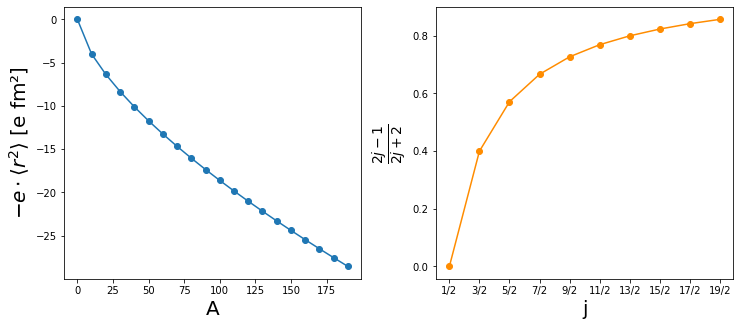

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Crear dos subgráficos en una fila

x1 = np.arange(0, 200, 10)
y1 = -1 * 3/5 * 1.2**2 * x1**(2/3)
axes[0].plot(x1, y1, "o-")
axes[0].set_xlabel("A", fontsize=20)
axes[0].set_ylabel(r"$-e\cdot\langle r^2 \rangle$ [e fm²]", fontsize=20)

x2 = np.arange(0.5, 10.5, 1)
y2 = (2 * x2 - 1) / (2 * x2 + 2)
axes[1].plot(x2, y2, "o-", color="darkorange")
axes[1].set_xlabel("j", fontsize=20)
axes[1].set_ylabel(r"$\frac{2j-1}{2j+2}$", fontsize=20)
axes[1].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2","15/2","17/2","19/2"])

plt.subplots_adjust(wspace=0.25)
plt.savefig("RvsJsp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()


In [27]:
Q_odd_A = Q.copy()
Q_odd_A["A"] = pd.to_numeric(Q_odd_A["A"], downcast='integer', errors='coerce')
Q_odd_A = Q_odd_A[Q_odd_A["A"]%2==1]
dataq = extract_q(Q_odd_A)

None of the available formats:


Z                                               48
Sym                                             Cd
A                                              109
E(level)                                       463
T_1/2                                       10.9µs
I                                            11/2-
Q(b)                                    [-0.92(9)]
Ref._Std.                                         
Method                                  systematic
NSR_Keynumber                                  not
Journal_reference    measured1978Sp09HFI4229(1978)
Name: 387, dtype: object

None of the available formats:


Z                                                    85
Sym                                                  At
A                                                   211
E(level)                                           1417
T_1/2                                            35.1ns
I                                                 21/2-
Q(b)                                     [(-)0.524(10)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1995Ba66NPA591104(1996)
Name: 1073, dtype: object

None of the available formats:


Z                                                 87
Sym                                               Fr
A                                                213
E(level)                                        2538
T_1/2                                          238ns
I                                              29/2+
Q(b)                                      [-0.70(7)]
Ref._Std.                                           
Method                                    calculated
NSR_Keynumber                                    not
Journal_reference    measured1990By03NPA516145(1990)
Name: 1112, dtype: object

None of the available formats:


Z                                                   91
Sym                                                 Pa
A                                                  231
E(level)                                             0
T_1/2                                         3.3x104y
I                                                 3/2-
Q(b)                                        [-1.72(5)]
Ref._Std.                                             
Method                                            from
NSR_Keynumber                                    B(E2)
Journal_reference    notmeasured1978Fr28PLA69225(1975)
Name: 1135, dtype: object

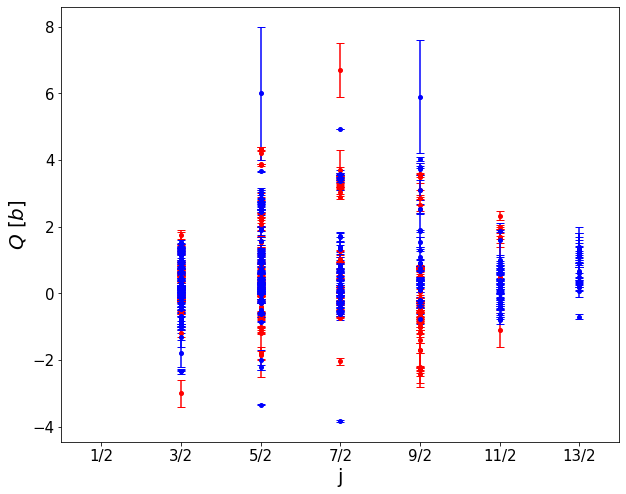

In [45]:
plt.figure(figsize=((10,8)))

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_mu_Z = [] 
dataq_lower_Z = [] 
dataq_upper_Z = [] 
#dataq_E_Z = [] 
dataq_jp_Z = []

# Odd N
#dataq_Z_N = [] 
#dataq_A_N = [] 
dataq_mu_N = [] 
dataq_lower_N = [] 
dataq_upper_N = [] 
#dataq_E_N = [] 
dataq_jp_N = []

for i in range(len(dataq[0])):
    
    if (dataq[0][i]%2==1):
        # Append in the odd Z array
        if "(" in dataq[5][i]:
            jjpp = dataq[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            
            if "/" not in dataq[5][i]:
                continue
            jjpp = float(dataq[5][i].split("/")[0])/2
            
        dataq_mu_Z.append(dataq[2][i])
        dataq_lower_Z.append(lower_error[i])
        dataq_upper_Z.append(upper_error[i])
        dataq_jp_Z.append(jjpp)
    
    if (dataq[0][i]%2==0):
        # Append in the odd N array
        if "(" in dataq[5][i]:
            jjpp = dataq[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            if "/" not in dataq[5][i]:
                continue
            jjpp = float(dataq[5][i].split("/")[0])/2
            
        dataq_mu_N.append(dataq[2][i])
        dataq_lower_N.append(lower_error[i])
        dataq_upper_N.append(upper_error[i])
        dataq_jp_N.append(jjpp)
    
asymmetric_error_Z = np.array(list(zip(dataq_lower_Z, dataq_upper_Z))).T
plt.errorbar(dataq_jp_Z, dataq_mu_Z, yerr=asymmetric_error_Z, fmt='o', color = "red" ,markersize=4, capsize=4) 
asymmetric_error_N = np.array(list(zip(dataq_lower_N, dataq_upper_N))).T
plt.errorbar(dataq_jp_N, dataq_mu_N, yerr=asymmetric_error_N, fmt='o', color = "blue", markersize=4, capsize=4) 


#plt.yticks(np.arange(int(min(dataq[2]))-1, int(max(dataq[2]))+2, 1), size=20)
plt.xlim(0,7)
#plt.ylim(-2.5,10.5)

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("j", size=20)
plt.ylabel(r"$Q$ [$b$]", size=20)
plt.show()

# Magnetic dipole moments

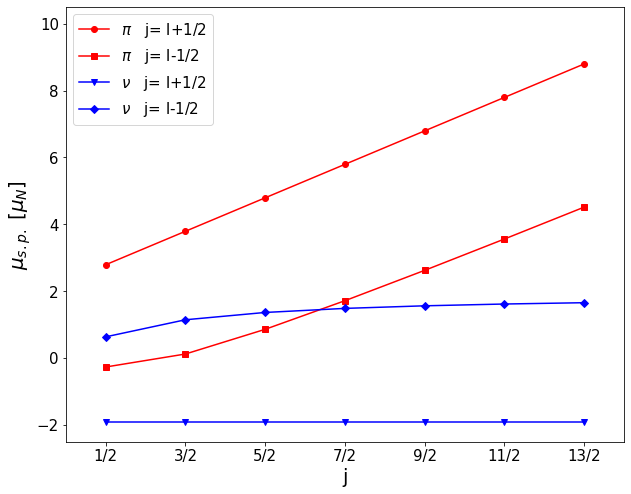

In [15]:
jj, mump, mupp, mumn, mupn = M_sp(13/2)

plt.figure(figsize=((10,8)))

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=15)
plt.yticks(fontsize=15)

plt.plot(jj, mupp ,"o-", c="red", label=r"$\pi$   j= l+1/2")
plt.plot(jj, mump ,"s-", c="red", label=r"$\pi$   j= l-1/2")

plt.plot(jj, mupn ,"v-", c="blue", label=r"$\nu$   j= l+1/2")
plt.plot(jj, mumn ,"D-", c="blue", label=r"$\nu$   j= l-1/2")

plt.xlabel("j", fontsize=20)
plt.ylabel(r"$\mu_{s.p.}$ [$\mu_N$]", fontsize=20)
plt.legend(fontsize=15)

plt.xlim(0,7)
plt.ylim(-2.5,10.5)

plt.savefig("Msp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [16]:
M_LL_Odd_A = M_LL.copy()
M_LL_Odd_A["A"] = pd.to_numeric(M_LL_Odd_A["A"], downcast='integer', errors='coerce')
M_LL_Odd_A = M_LL_Odd_A[M_LL_Odd_A["A"]%2==1]
datamll = extract_mu(M_LL_Odd_A)

Data with none of the available formats:


Z                                                  85
Sym                                                At
A                                                 211
Ex                                                  0
T1/2                                            7.21h
Jπ                                               9/2-
m(nm)                Ref.estimated+4.14(not_measured)
Method                                       2018Cu02
NSR_Keynumber                                      PR
Journal_Reference                     C97054327(2018)
Name: 1099, dtype: object

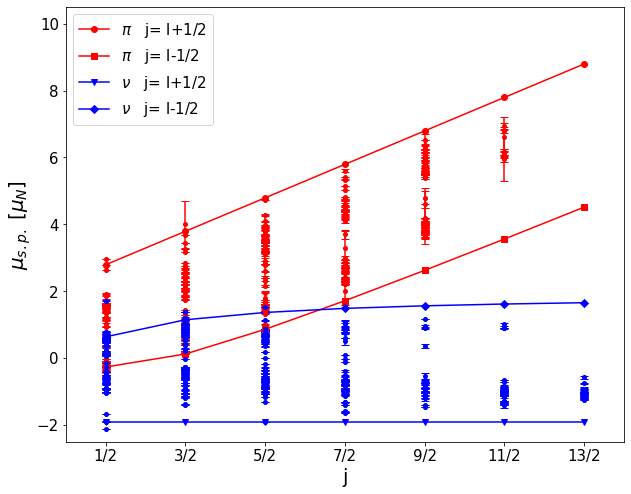

In [17]:
plt.figure(figsize=((10,8)))

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(datamll[3])):
    try: 
        if len(datamll[3][i]) == 2:
            lower_error.append(datamll[3][i][1])
            upper_error.append(datamll[3][i][0])
    except: 
        lower_error.append(datamll[3][i])
        upper_error.append(datamll[3][i])
# =================================================================================        

# Odd Z
#datamll_Z_Z = [] 
#datamll_A_Z = [] 
datamll_mu_Z = [] 
datamll_lower_Z = [] 
datamll_upper_Z = [] 
#datamll_E_Z = [] 
datamll_jp_Z = []

# Odd N
#datamll_Z_N = [] 
#datamll_A_N = [] 
datamll_mu_N = [] 
datamll_lower_N = [] 
datamll_upper_N = [] 
#datamll_E_N = [] 
datamll_jp_N = []

for i in range(len(datamll[0])):
    
    if (datamll[0][i]%2==1):
        # Append in the odd Z array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            
        datamll_mu_Z.append(datamll[2][i])
        datamll_lower_Z.append(lower_error[i])
        datamll_upper_Z.append(upper_error[i])
        datamll_jp_Z.append(jjpp)
    
    if (datamll[0][i]%2==0):
        # Append in the odd N array
        if "(" in datamll[5][i]:
            jjpp = datamll[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            jjpp = float(datamll[5][i].split("/")[0])/2
            
        datamll_mu_N.append(datamll[2][i])
        datamll_lower_N.append(lower_error[i])
        datamll_upper_N.append(upper_error[i])
        datamll_jp_N.append(jjpp)
    
asymmetric_error_Z = np.array(list(zip(datamll_lower_Z, datamll_upper_Z))).T
plt.errorbar(datamll_jp_Z, datamll_mu_Z, yerr=asymmetric_error_Z, fmt='o', color = "red" ,markersize=4, capsize=4) 
asymmetric_error_N = np.array(list(zip(datamll_lower_N, datamll_upper_N))).T
plt.errorbar(datamll_jp_N, datamll_mu_N, yerr=asymmetric_error_N, fmt='o', color = "blue", markersize=4, capsize=4) 


#plt.yticks(np.arange(int(min(datamll[2]))-1, int(max(datamll[2]))+2, 1), size=20)
plt.xlim(0,7)
plt.ylim(-2.5,10.5)

plt.xlabel("Z", size=30)
plt.ylabel(r"$\mu$ [$\mu_N$]", size=30)

#####################################################################################################
# Schmidt lines
#####################################################################################################

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=15)
plt.yticks(fontsize=15)

plt.plot(jj, mupp ,"o-", c="red", label=r"$\pi$   j= l+1/2")
plt.plot(jj, mump ,"s-", c="red", label=r"$\pi$   j= l-1/2")

plt.plot(jj, mupn ,"v-", c="blue", label=r"$\nu$   j= l+1/2")
plt.plot(jj, mumn ,"D-", c="blue", label=r"$\nu$   j= l-1/2")

plt.xlabel("j", fontsize=20)
plt.ylabel(r"$\mu_{s.p.}$ [$\mu_N$]", fontsize=20)
plt.legend(fontsize=15)

plt.savefig("Msp+Exp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()



### Long lived ones only